In [1]:
import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
#import plotly.express as px
#import glob
#import plotly.graph_objects as go
#
from sklearn.preprocessing import MinMaxScaler#, StandardScaler
#from tensorflow.keras.layers import Input, Dense, Activation, Lambda
#from tensorflow.keras.models import Sequential, Model
#from tensorflow.keras.losses import MeanSquaredError, MeanSquaredError
#
#import random
import numpy as np
#from keras import backend as K
#import os
#from contextlib import redirect_stdout
#
import tensorflow as tf
#
#tf.keras.backend.set_floatx('float32')
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
num_hidden_nodes = [16, 32]
activations = 2*['tanh']
num_atoms = 40

In [3]:
def my_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=0)

In [4]:
X_train_cycles = pd.read_parquet('X_'+'cycles'+'_train.parquet')
X_dev_cycles = pd.read_parquet('X_'+'cycles'+'_dev.parquet')
X_test_cycles = pd.read_parquet('X_'+'cycles'+'_test.parquet')

scaler = MinMaxScaler().fit(X_train_cycles)
    
X_train_cycles = pd.DataFrame(scaler.transform(
    X_train_cycles), columns=X_train_cycles.columns, index=X_train_cycles.index)
X_dev_cycles = pd.DataFrame(scaler.transform(
    X_dev_cycles), columns=X_dev_cycles.columns, index=X_dev_cycles.index)
X_test_cycles = pd.DataFrame(scaler.transform(
    X_test_cycles), columns=X_test_cycles.columns, index=X_test_cycles.index)

In [5]:
f_train = pd.read_parquet('y_train.parquet').loc[:, [
    'fx', 'fy', 'fz']].astype('float32').values.reshape(-1, num_atoms, 3)
    
f_dev = pd.read_parquet('y_dev.parquet').loc[:, [
    'fx', 'fy', 'fz']].astype('float32').values.reshape(-1, num_atoms, 3)
    
f_test = pd.read_parquet('y_test.parquet').loc[:, [
    'fx', 'fy', 'fz']].astype('float32').values.reshape(-1, num_atoms, 3)

In [6]:
def get_features(features, num_hidden_nodes, activations, num_atoms):


    # %%
    network = '_'.join([str(x) for x in num_hidden_nodes])
    model_name = features+'--'+network+activations[0]
    
    f_type, n_hops, n_nei = model_name.split('-')[0], *re.findall('\d+', features)
    
    cols_hops = X_train_cycles.columns[X_train_cycles.columns.str.startswith(
    tuple(str(x)+'_(' for x in range(int(n_hops)+1)))]
    cols_neis = X_train_cycles.columns[X_train_cycles.columns.str.startswith(
    tuple(str(x)+'_[' for x in range(int(n_nei)+1)))]
    cols = cols_hops.to_list()+cols_neis.to_list()+['Atom']
    X_train = X_train_cycles.loc[:, cols]
    X_dev = X_dev_cycles.loc[:, cols]
    X_test = X_test_cycles.loc[:, cols]        
    
    # %%

    
    X_train2 = X_train.to_numpy().reshape(-1, num_atoms, X_train.shape[-1])
    X_dev2 = X_dev.to_numpy().reshape(-1, num_atoms, X_dev.shape[-1])
    X_test2 = X_test.to_numpy().reshape(-1,  num_atoms, X_test.shape[-1])
    
    model = tf.keras.models.load_model('./results/'+model_name+'/checkpoints', compile = False)#, custom_objects={'loss': my_loss_fn})
    
    predictions = {}
    xs2 = [X_train2, X_dev2, X_test2]
    ys2 = [f_train, f_dev, f_test]
    xs = [X_train, X_dev, X_test]
    
    return(model, xs, xs2, ys2, n_hops, n_nei)


In [7]:
def predict(model, xs, xs2, ys2):
    predictions = {}
    for i, set in enumerate(['train', 'dev', 'test']):
        xvals = xs2[i]  # .to_numpy().reshape(-1, num_atoms, xs[i].shape[-1])
        y_pred2 = model.predict_on_batch(xvals)
        y_pred = pd.DataFrame(y_pred2.reshape(-1, 3),
                              columns=['x_hat', 'y_hat', 'z_hat'], index=xs[i].index)
        y_real = pd.DataFrame(ys2[i].reshape(-1, 3),
                              columns=['x', 'y', 'z'], index=xs[i].index)
        df_pred = pd.concat([y_real, y_pred], axis=1)
        predictions[set] = df_pred
    df_pred = pd.concat(predictions)
    df_pred['f'] = np.sqrt((df_pred[['x', 'y', 'z']]**2).sum(axis=1))
    df_pred['f_hat'] = np.sqrt((df_pred[['x_hat', 'y_hat', 'z_hat']]**2).sum(axis=1))

    return(df_pred)


In [8]:

def get_vectors(features_list):
    labels_list = []
    preds = {}
    preds_vector = {}

    for features in features_list:
        model, xs, xs2, ys2, n_hop, n_nei = get_features(features, num_hidden_nodes, activations, num_atoms)
        labels_list.append([n_hop, n_nei])
        preds[features] = predict(model, xs, xs2, ys2)
        print(features, xs[0].shape)
        mae = np.abs((preds[features].loc[:, ['x', 'y', 'z']]).values - (preds[features].loc[:, ['x_hat', 'y_hat', 'z_hat']]).values)
        preds_vector[features] = pd.DataFrame(mae.reshape(-1))
        new_index = []
        for item in preds[features].index.to_list():
            item = list(item)
            a, b = item[1].split('--')
            c, e = a.split('_')
            item.extend([c, e, a, b])
            for d in ['x', 'y', 'z']:
                new_index.append(item + [d])
        preds_vector[features][['set', 'index', 'atom', 'atom_number', 'atom+number','structure', 'direction']] = new_index
        df = pd.concat(preds_vector).reset_index()
        df.columns = ['Features', 'level_1','MAE Forces', 'set', 'old_index', 'Atom', 'atom_number', 'atom+number', 'structure', 'Direction']
        df = df.drop('level_1', axis = 1)
    return(df, labels_list, preds_vector, preds, )

In [9]:
features_list = ['cycles-exp6-coords4', 'cycles-exp4-coords4', 'cycles-exp6-coords3', 'cycles-exp6-coords2', 'cycles-exp4-coords2', 'cycles-exp6-coords1']

df, labels_list, preds_vector, preds = get_vectors(features_list)

cycles-exp6-coords4 (30000, 21229)
cycles-exp4-coords4 (30000, 19285)
cycles-exp6-coords3 (30000, 5245)
cycles-exp6-coords2 (30000, 2365)
cycles-exp4-coords2 (30000, 421)
cycles-exp6-coords1 (30000, 2125)


In [10]:
df.groupby(['Features', 'set'])['MAE Forces'].describe()[['mean', 'std']].xs('test', level=1, drop_level=True).sort_values(by = 'mean')

,mean,std
Features,,
cycles-exp4-coords4,0.033513,0.035256
cycles-exp6-coords4,0.037801,0.040543
cycles-exp4-coords2,0.066476,0.058900
cycles-exp6-coords3,0.072824,0.073091
cycles-exp6-coords2,0.078789,0.073164
cycles-exp6-coords1,0.117691,0.132661


FileNotFoundError: [Errno 2] No such file or directory: './figures/MO-violin.svg'

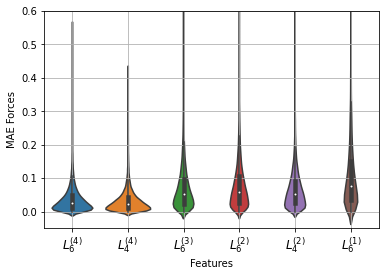

In [11]:
fig, ax = plt.subplots()

sns.violinplot(data = df[df['set'] == 'test'], y = 'MAE Forces', x = 'Features', ax = ax)
ax.set_xticklabels([r'$L_{'+x[0]+r'}' + r'^{(' + x[1] + r')}$' for x in labels_list], fontdict={'fontsize': 12})
plt.grid()
ax.set_ylim(top = 0.6, bottom = -0.05)
plt.savefig('./figures/MO-violin.svg', dpi = 400)
plt.savefig('./figures/MO-violin.pdf', dpi = 400)
